In [20]:
from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from io import BytesIO
import requests
import gc

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention, add
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.optimizers import Adam
from keras_applications.xception import Xception, preprocess_input
from keras_preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model, load_model


In [21]:
# URL del archivo JSON de COCO
url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

# Descarga el archivo
response = requests.get(url)
response.raise_for_status()  # Asegúrate de que la solicitud fue exitosa

# Extrae el archivo JSON de la respuesta (asumiendo que el archivo JSON está en un ZIP)
from zipfile import ZipFile

with ZipFile(BytesIO(response.content)) as the_zip:
    with the_zip.open('annotations/instances_train2017.json') as file:
        coco_data = json.load(file)

# Carga los datos en el objeto COCO
coco = COCO()
coco.dataset = coco_data
coco.createIndex()

creating index...
index created!


In [22]:
#Identificar Categorias

cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Número de categorías principales: ", len(maincategories))
print("Lista de categorías principales: ", maincategories)

Número de categorías principales:  12
Lista de categorías principales:  ['animal', 'kitchen', 'indoor', 'outdoor', 'sports', 'appliance', 'person', 'vehicle', 'furniture', 'food', 'accessory', 'electronic']


In [23]:
#Identificar Sub-Categorías

subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)

Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [24]:
#Sub-categorías con su correspondientes IDs

catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categorías con IDs :",subcategories_Ids)

Sub categorías con IDs : {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'ce

In [25]:
#Total de imágenes para cada sub categoría

subcategories_imageIds = dict()

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    img = []
    for j in imgIds:
        img.append(j)
    subcategories_imageIds[subcategories[i]] = img

print("Sub-categorias con Image IDs :",len(subcategories_imageIds))

Sub-categorias con Image IDs : 80


In [26]:
length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Imágenes totales en cada sub categoría: ", length_dict)

Imágenes totales en cada sub categoría:  {'person': 64115, 'bicycle': 3252, 'car': 12251, 'motorcycle': 3502, 'airplane': 2986, 'bus': 3952, 'train': 3588, 'truck': 6127, 'boat': 3025, 'traffic light': 4139, 'fire hydrant': 1711, 'stop sign': 1734, 'parking meter': 705, 'bench': 5570, 'bird': 3237, 'cat': 4114, 'dog': 4385, 'horse': 2941, 'sheep': 1529, 'cow': 1968, 'elephant': 2143, 'bear': 960, 'zebra': 1916, 'giraffe': 2546, 'backpack': 5528, 'umbrella': 3968, 'handbag': 6841, 'tie': 3810, 'suitcase': 2402, 'frisbee': 2184, 'skis': 3082, 'snowboard': 1654, 'sports ball': 4262, 'kite': 2261, 'baseball bat': 2506, 'baseball glove': 2629, 'skateboard': 3476, 'surfboard': 3486, 'tennis racket': 3394, 'bottle': 8501, 'wine glass': 2533, 'cup': 9189, 'fork': 3555, 'knife': 4326, 'spoon': 3529, 'bowl': 7111, 'banana': 2243, 'apple': 1586, 'sandwich': 2365, 'orange': 1699, 'broccoli': 1939, 'carrot': 1683, 'hot dog': 1222, 'pizza': 3166, 'donut': 1523, 'cake': 2925, 'chair': 12774, 'couch':

In [27]:
#Se seleccionan dos subcategorías Bicicleta y Avión para llevar a cabo 
#el proyecto generador de leyendas de imágenes

train_cats = subcategories_imageIds['bicycle'] + subcategories_imageIds['airplane']
imgIdss = coco.getImgIds(imgIds = train_cats)
print("Total Images: ", len(imgIdss))

Total Images:  6221


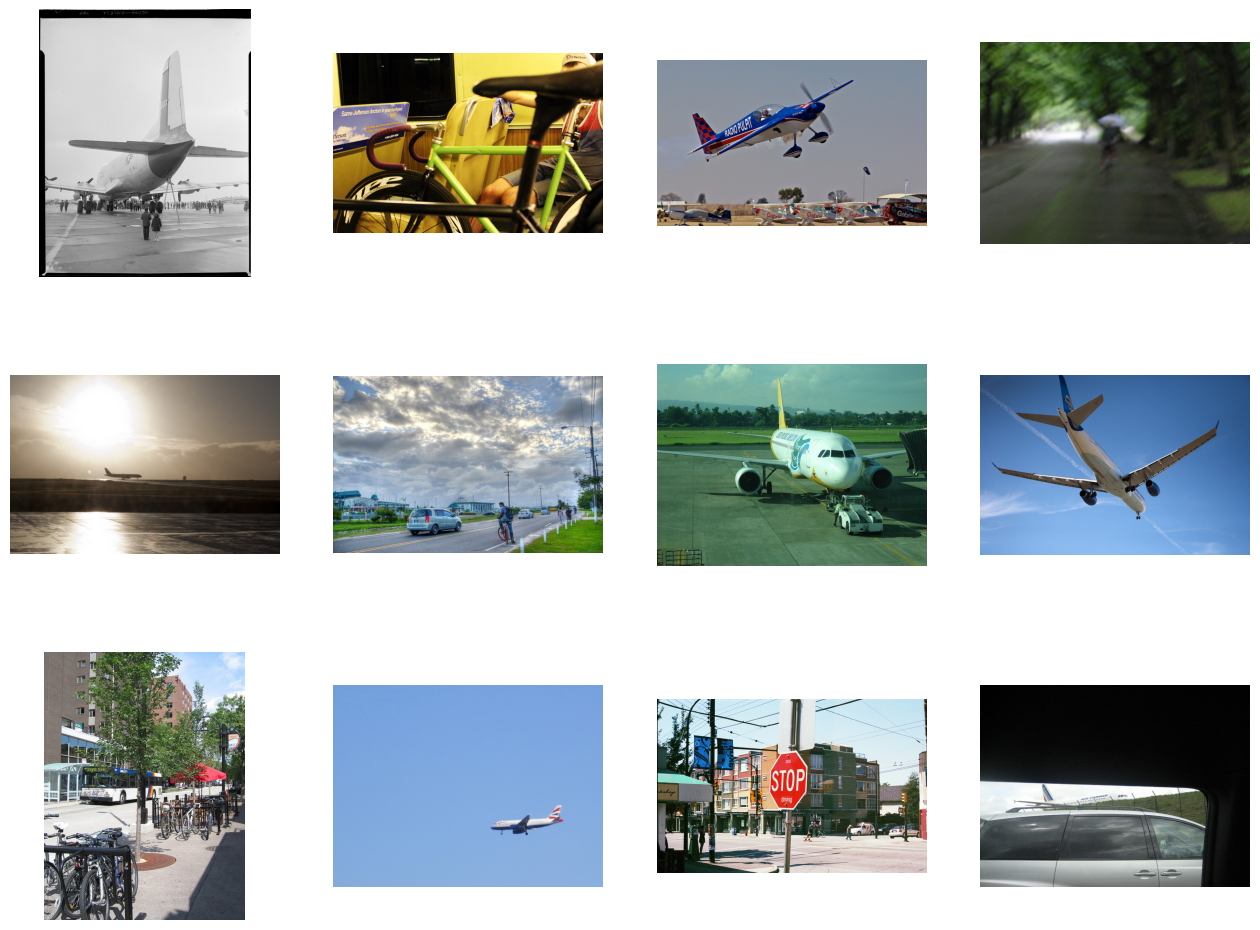

In [28]:
#Cargamos algunas imagenes aleatorias

fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):

    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

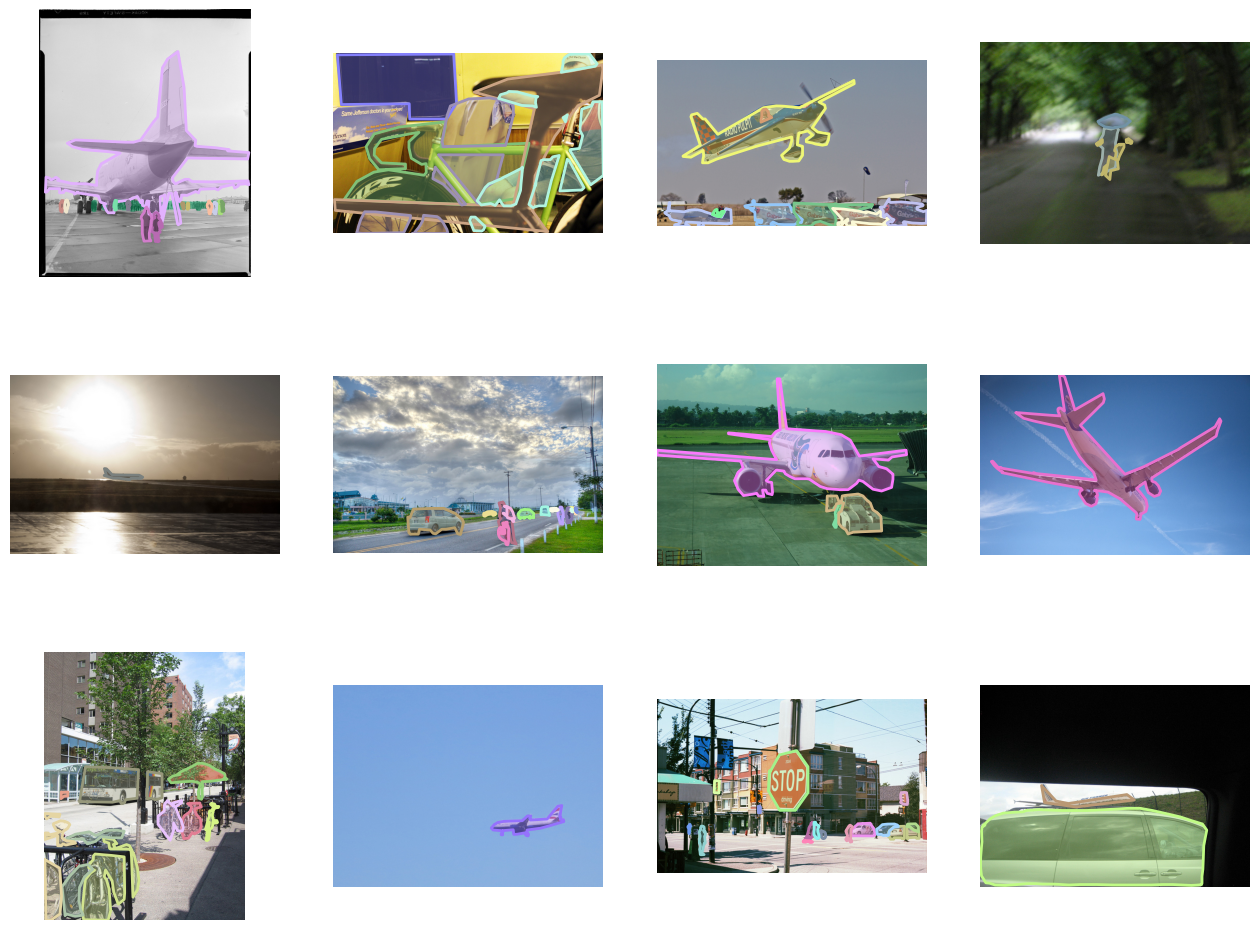

In [29]:
#Cargamos esas imagenes con objetos segmentados en ellas

fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):

    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    # print(anns)
    coco.showAnns(anns)


plt.show()

In [30]:
# Cargamos las imagenes con keypoints en ellas

# URL del archivo JSON de COCO (dentro de un archivo ZIP)
url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

# Descarga el archivo ZIP
response = requests.get(url)
response.raise_for_status()  # Asegúrate de que la solicitud fue exitosa

# Extrae el archivo JSON del ZIP en memoria
with ZipFile(BytesIO(response.content)) as the_zip:
    with the_zip.open('annotations/person_keypoints_train2017.json') as file:
        coco_data = json.load(file)
        
# Inicializa y carga los datos en el objeto COCO
coco_kps = COCO()
coco_kps.dataset = coco_data
coco_kps.createIndex()

creating index...
index created!


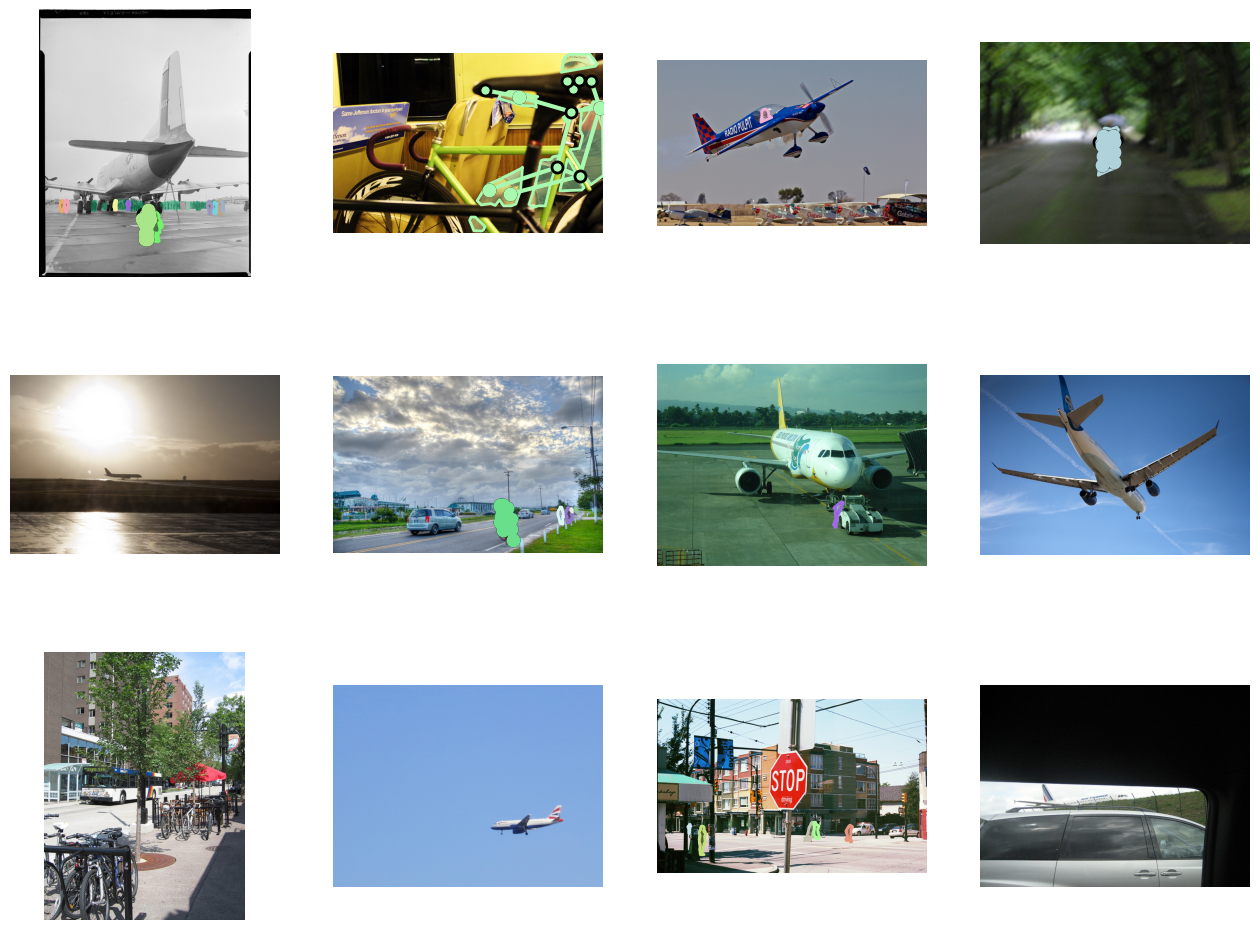

In [31]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    coco_kps.showAnns(anns)
    

plt.show()

In [32]:
# Cargamos las imágenes con sus correspondientes subtítulos
# URL del archivo ZIP que contiene los archivos JSON de COCO
zip_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

# Descarga el archivo ZIP
response = requests.get(zip_url)
response.raise_for_status()  # Asegúrate de que la solicitud fue exitosa

# Extrae el archivo JSON 'captions_train2017.json' del ZIP en memoria
with ZipFile(BytesIO(response.content)) as the_zip:
    with the_zip.open('annotations/captions_train2017.json') as file:
        coco_data = json.load(file)

# Inicializa y carga los datos en el objeto COCO
coco_caps = COCO()
coco_caps.dataset = coco_data
coco_caps.createIndex()

creating index...
index created!


A group of people standing on the ground underneath an airplane.
A large jet sitting on top of an airport tarmac.
a bunch of people watch a big parked jumbo jet 
Two children stand beneath the tail of an airliner near many others. 
A airplane that is sitting on a tarmac.


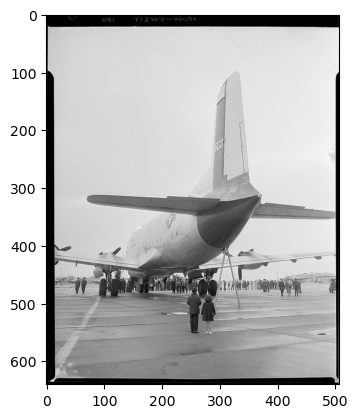

In [33]:
img = coco.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

a close up of a bike with another bike in the background
there is a bike that is on a train next to the seats
A man riding a bus with several bicycles parked near him.
A pair of bicycles inside of an office with a television and a person.
A bright green bicycle on public transportation. 


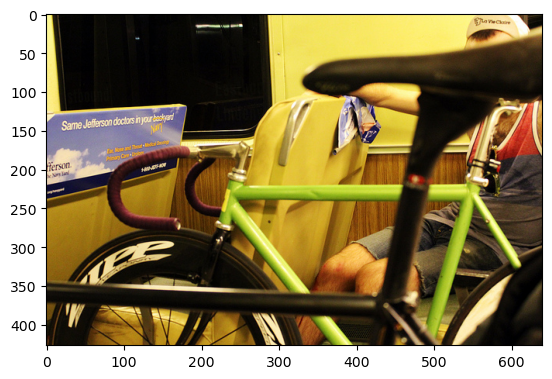

In [34]:
img = coco.loadImgs(next_pix[1])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

A stop sign at a city street intersection with young people ridding skateboards and bicycles.
A stop sign is standing in the middle of the street as people skate past in the background.
A stop sign that is at the corner of a street.
A stop sign on a street where people walk and ride bikes.
A stop sign at a busy city intersection.


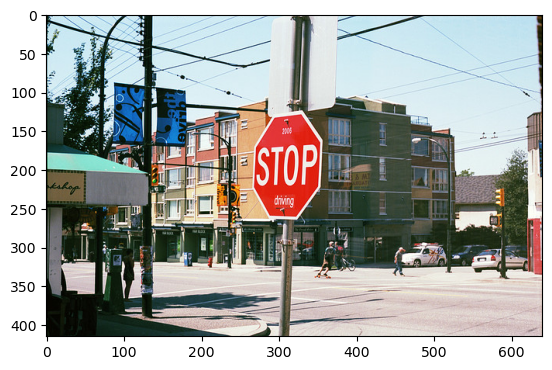

In [35]:
img = coco.loadImgs(next_pix[10])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

In [36]:
#ESTO HAY QUE PONERLO AL FINAL DEL TODO, SI NO BORRA LA ASIGNACIÓN DE VARIABLES !!!!!!
# Liberar memoria explícitamente

del coco_data
del coco
del coco_kps  # Elimina la referencia al objeto de datos cargado
del coco_caps  # Elimina la referencia al objeto COCO

# Llama al recolector de basura para liberar memoria no utilizada
gc.collect()

36921